In [1]:
"""
#This script demonstrates the use of a convolutional LSTM network.
This network is used to predict the next frame of an artificially
generated movie which contains moving squares.
"""
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

In [3]:
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 40, 40, 40)  59200     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
__________

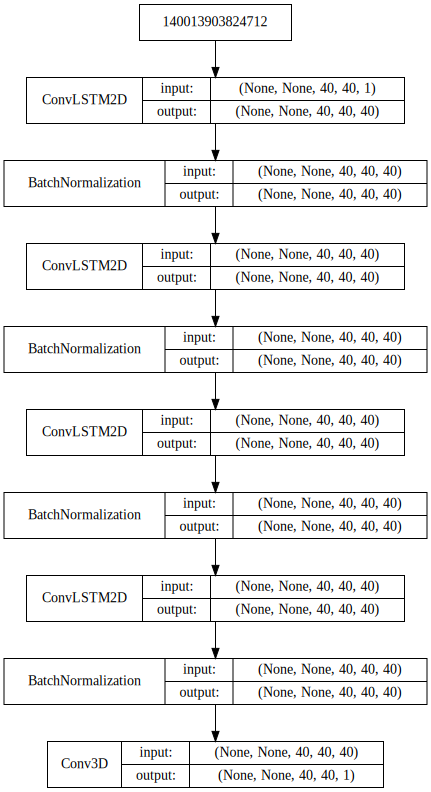

In [4]:
#  Display Model in Jupyter notebook

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_keras_model(model,show_shapes=True,show_layer_names=True):
    return SVG(model_to_dot(model,show_shapes=show_shapes,show_layer_names=show_layer_names).create(prog='dot',format='svg'))

plot_keras_model(seq, show_shapes=True, show_layer_names=False)

In [5]:
# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1 # [-1,0,1]
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    
    # clipping
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [6]:
# generate data
noisy_movies, shifted_movies = generate_movies(n_samples=1200)  # n_frames = 15

In [7]:
noisy_movies[0][0].shape

(40, 40, 1)

In [8]:
np.set_printoptions(threshold=np.inf)
noisy_movies[0][0][:,:,0]

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.1,
         0.9,  0.9,  0.9,  0.9,  0.9,  0.9, -0.1,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.1,
         0.9,  0.9,  0.9,  0.9,  0.9,  0.9, -0.1,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.1,
         0.9,  0.9,  0.9,  0.9,  0.9,  0.9, -0.1,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.1,
         0.9,  0.9,  0.9,  0.9,  0.9,  0.9, -0.1,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  

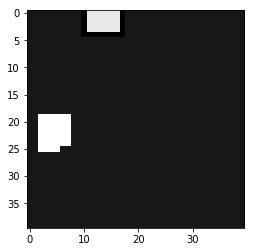

In [9]:
# plt.imshow(noisy_movies[0][0], cmap='gray', vmin=0, vmax=255)
# plt.show()

plt.imshow(noisy_movies[0][0].reshape(40,40), cmap=plt.get_cmap('gray'))

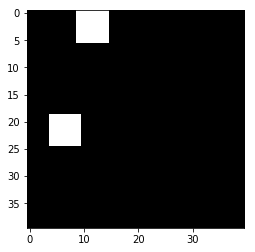

In [10]:
plt.imshow(shifted_movies[0][1].reshape(40,40), cmap=plt.get_cmap('gray'))

In [4]:
# Train the network
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=300, validation_split=0.05)

Train on 950 samples, validate on 50 samples
Epoch 1/300
950/950 [==============================] - 32s 33ms/step - loss: 0.2379 - val_loss: 0.1487
Epoch 2/300
950/950 [==============================] - 27s 29ms/step - loss: 0.0199 - val_loss: 0.0085
Epoch 3/300
950/950 [==============================] - 27s 28ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 4/300
950/950 [==============================] - 27s 28ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 5/300
950/950 [==============================] - 27s 29ms/step - loss: 7.3965e-04 - val_loss: 6.8323e-04
Epoch 6/300
950/950 [==============================] - 27s 29ms/step - loss: 5.6602e-04 - val_loss: 5.3474e-04
Epoch 7/300
950/950 [==============================] - 27s 29ms/step - loss: 4.6738e-04 - val_loss: 4.9350e-04
Epoch 8/300
950/950 [==============================] - 27s 29ms/step - loss: 3.9590e-04 - val_loss: 4.0058e-04
Epoch 9/300
950/950 [==============================] - 27s 29ms/step - loss: 3.4464e-04 - val_loss:

950/950 [==============================] - 27s 29ms/step - loss: 3.7914e-05 - val_loss: 1.5751e-04
Epoch 75/300
950/950 [==============================] - 27s 29ms/step - loss: 3.7662e-05 - val_loss: 1.5174e-04
Epoch 76/300
950/950 [==============================] - 27s 29ms/step - loss: 3.6927e-05 - val_loss: 1.4793e-04
Epoch 77/300
950/950 [==============================] - 27s 29ms/step - loss: 3.7008e-05 - val_loss: 1.4023e-04
Epoch 78/300
950/950 [==============================] - 27s 29ms/step - loss: 3.5861e-05 - val_loss: 1.5237e-04
Epoch 79/300
950/950 [==============================] - 27s 29ms/step - loss: 3.5540e-05 - val_loss: 1.4791e-04
Epoch 80/300
950/950 [==============================] - 27s 29ms/step - loss: 3.4342e-05 - val_loss: 1.4756e-04
Epoch 81/300
950/950 [==============================] - 27s 29ms/step - loss: 3.2350e-05 - val_loss: 1.5014e-04
Epoch 82/300
950/950 [==============================] - 27s 29ms/step - loss: 3.1344e-05 - val_loss: 1.4799e-04
Epoch

Epoch 147/300
950/950 [==============================] - 27s 29ms/step - loss: 1.0106e-05 - val_loss: 1.6288e-04
Epoch 148/300
950/950 [==============================] - 27s 29ms/step - loss: 1.0248e-05 - val_loss: 1.6036e-04
Epoch 149/300
950/950 [==============================] - 27s 29ms/step - loss: 9.8446e-06 - val_loss: 1.5823e-04
Epoch 150/300
950/950 [==============================] - 27s 29ms/step - loss: 1.0042e-05 - val_loss: 1.6302e-04
Epoch 151/300
950/950 [==============================] - 27s 29ms/step - loss: 1.0047e-05 - val_loss: 1.6506e-04
Epoch 152/300
950/950 [==============================] - 27s 29ms/step - loss: 9.5957e-06 - val_loss: 1.6280e-04
Epoch 153/300
950/950 [==============================] - 27s 29ms/step - loss: 9.5473e-06 - val_loss: 1.8251e-04
Epoch 154/300
950/950 [==============================] - 27s 29ms/step - loss: 9.4522e-06 - val_loss: 1.6097e-04
Epoch 155/300
950/950 [==============================] - 27s 29ms/step - loss: 1.0034e-05 - val_

950/950 [==============================] - 27s 29ms/step - loss: 4.8125e-06 - val_loss: 1.7367e-04
Epoch 220/300
950/950 [==============================] - 27s 29ms/step - loss: 4.6945e-06 - val_loss: 1.7457e-04
Epoch 221/300
950/950 [==============================] - 27s 29ms/step - loss: 4.3797e-06 - val_loss: 1.7644e-04
Epoch 222/300
950/950 [==============================] - 27s 29ms/step - loss: 4.5575e-06 - val_loss: 1.7684e-04
Epoch 223/300
950/950 [==============================] - 27s 29ms/step - loss: 4.5025e-06 - val_loss: 1.7424e-04
Epoch 224/300
950/950 [==============================] - 27s 29ms/step - loss: 4.7172e-06 - val_loss: 1.7087e-04
Epoch 225/300
950/950 [==============================] - 27s 29ms/step - loss: 4.5788e-06 - val_loss: 1.6689e-04
Epoch 226/300
950/950 [==============================] - 27s 29ms/step - loss: 4.7369e-06 - val_loss: 1.7690e-04
Epoch 227/300
950/950 [==============================] - 27s 29ms/step - loss: 4.4035e-06 - val_loss: 1.8127e-

950/950 [==============================] - 27s 29ms/step - loss: 2.9240e-06 - val_loss: 1.8727e-04
Epoch 292/300
950/950 [==============================] - 27s 29ms/step - loss: 2.7586e-06 - val_loss: 1.8377e-04
Epoch 293/300
950/950 [==============================] - 27s 29ms/step - loss: 2.7449e-06 - val_loss: 1.8494e-04
Epoch 294/300
950/950 [==============================] - 27s 29ms/step - loss: 2.7441e-06 - val_loss: 1.8070e-04
Epoch 295/300
950/950 [==============================] - 27s 29ms/step - loss: 2.8905e-06 - val_loss: 1.8358e-04
Epoch 296/300
950/950 [==============================] - 27s 29ms/step - loss: 2.7231e-06 - val_loss: 1.8192e-04
Epoch 297/300
950/950 [==============================] - 27s 29ms/step - loss: 2.6448e-06 - val_loss: 1.8228e-04
Epoch 298/300
950/950 [==============================] - 27s 29ms/step - loss: 2.5513e-06 - val_loss: 1.8327e-04
Epoch 299/300
950/950 [==============================] - 27s 29ms/step - loss: 2.8308e-06 - val_loss: 1.8414e-

In [11]:
# # save weight
# seq.save("pretrained.h5")

#load model
import keras
seq=keras.models.load_model("pretrained.h5")

In [16]:
# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1005
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)

In [19]:
track.shape

(23, 40, 40, 1)

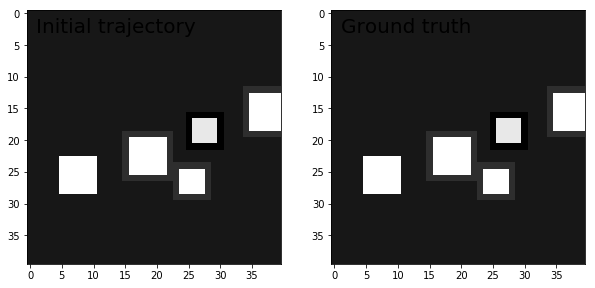

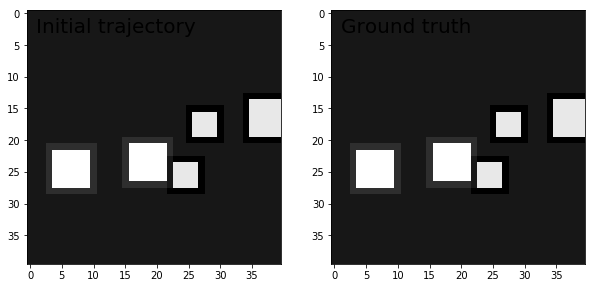

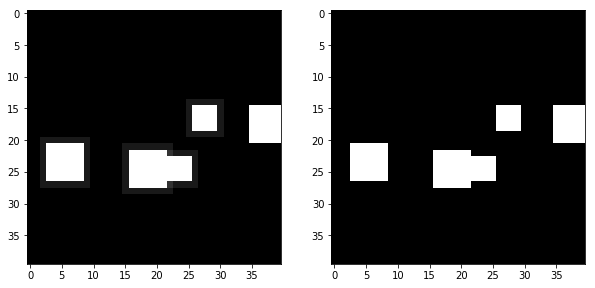

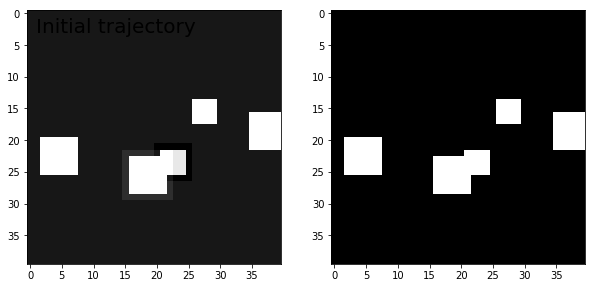

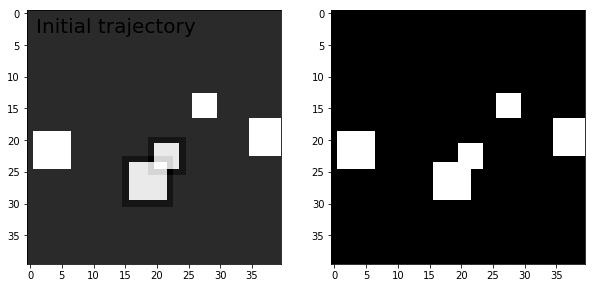

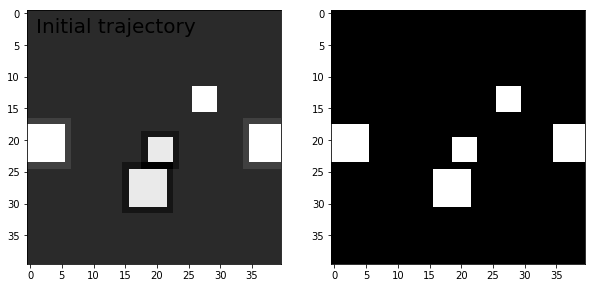

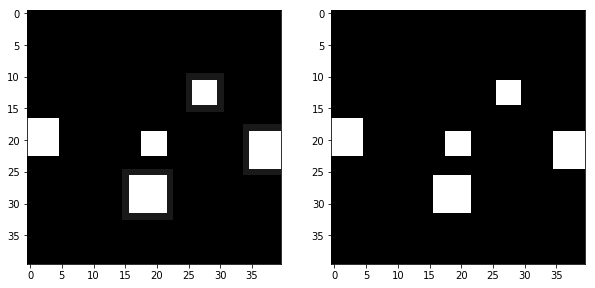

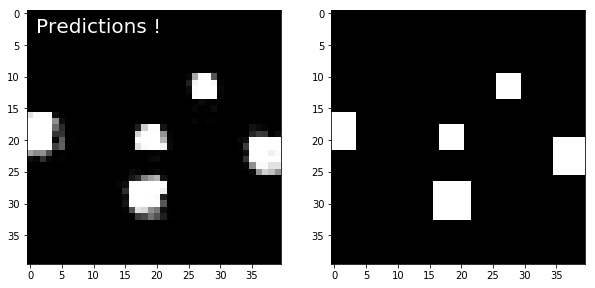

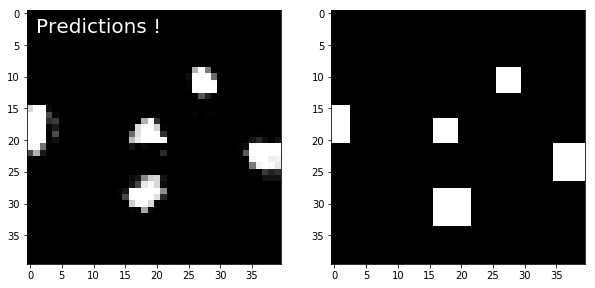

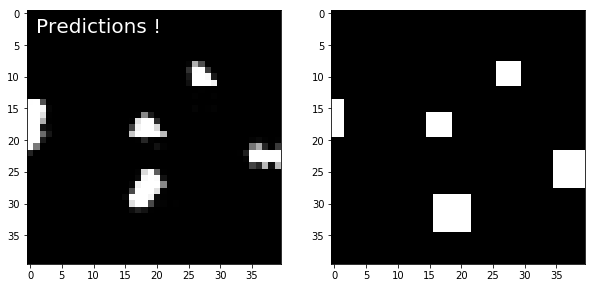

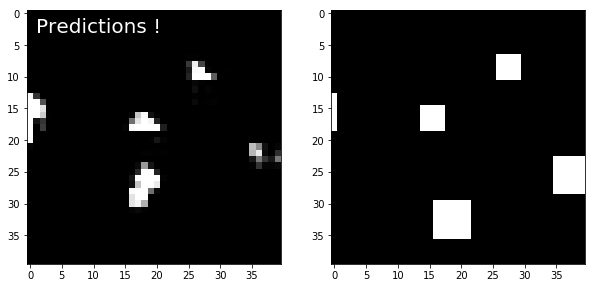

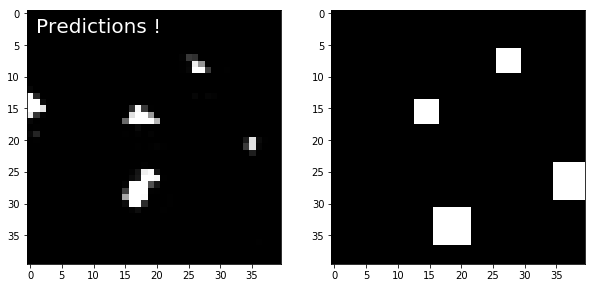

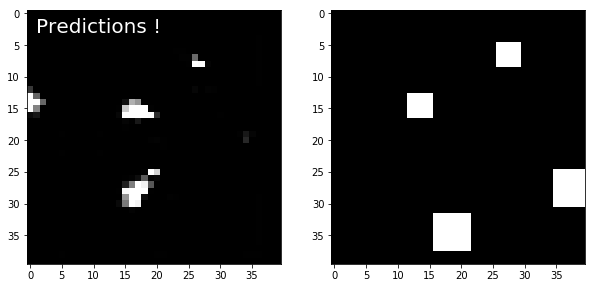

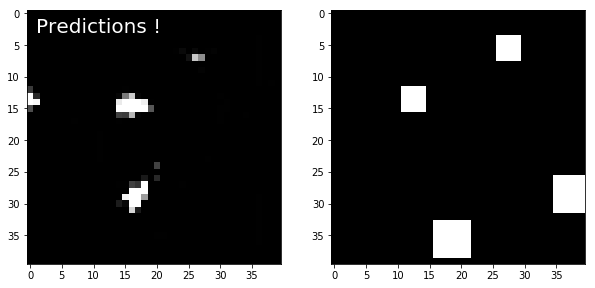

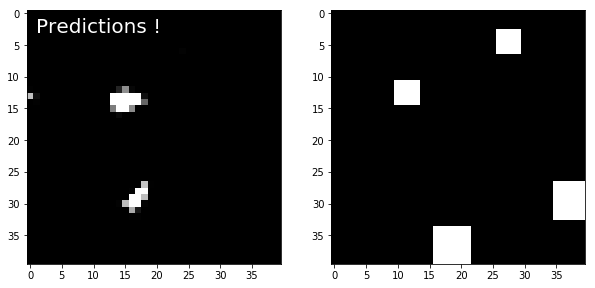

In [21]:
# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]
    plt.imshow(toplot.reshape(40,40), cmap=plt.get_cmap('gray'))
#     plt.imshow(toplot)
    
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)
    toplot = track2[i, ::, ::, 0]
    
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot.reshape(40,40), cmap=plt.get_cmap('gray'))
#     plt.imshow(toplot)
#     plt.savefig('%i_animate.png' % (i + 1))

# End

# test code

In [33]:
which = 1004 # 1001 ~ 1199 is for test
noisy_movies[which][:, ::, ::, ::].shape

(15, 40, 40, 1)

In [34]:
test_track = noisy_movies[which][:7, ::, ::, ::]
test_track.shape

(7, 40, 40, 1)

In [35]:
test_track[np.newaxis, ::, ::, ::, ::].shape

(1, 7, 40, 40, 1)

In [36]:
test_new_pos1 = seq.predict(test_track[np.newaxis, ::, ::, ::, ::])
print(test_new_pos1.shape)

(1, 7, 40, 40, 1)


In [37]:
for j in range(16):
    test_new_pos2 = seq.predict(test_track[np.newaxis, ::, ::, ::, ::])

In [38]:
test_new_pos2.shape

(1, 7, 40, 40, 1)

In [39]:
test_track2 = noisy_movies[which][::, ::, ::, ::]
test_track2.shape

(15, 40, 40, 1)

In [ ]:
for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])# And then compare the predictions
# to the ground truth


In [55]:
if True:
    x = 1
print(x)

1
